<center><h1>Calculating errors on the forecasts using hindcasts<h1></center>
 <center><img src="../AC_logo.png"></center>

## Importing Modules

In [1]:
# Two modules included with anaconda distribution

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import warnings
from sklearn import metrics
warnings.filterwarnings('ignore')
%matplotlib inline

# Bespoke modules created using pyro to perform the Gaussian processes and then create reports.

import Forecasting

## Load in the data


In [2]:
# Loading in VCI data

Data = np.load('..\Data\VCI_Time_Series.npz',allow_pickle=True)

# Picking a county to run the GP on 

County = 'Kitui'

# Making sure each array has the correct format

Dates,VCI1W,VCI3M = np.array(Data[County][0],dtype=object),np.array(Data[County][2],dtype=float),np.array(Data[County][3],dtype=float)

# Errors will not be loaded in this time as they will be created here.

## The county list

In [3]:
# This cell simply goes through the file and shows what counties can be chosen.
# Simply copy and paste the county wanted into the cell above.

Counties = [] 
for item in Data:
    Counties.append(item)
print(Counties)

['Mombasa', 'Kwale', 'Kilifi', 'TanaRiver', 'Lamu', 'TaitaTaveta', 'Garissa', 'Wajir', 'Mandera', 'Marsabit', 'Isiolo', 'Meru', 'TharakaNithi', 'Embu', 'Kitui', 'Machakos', 'Makueni', 'Nyandarua', 'Nyeri', 'Kirinyaga', 'Muranga', 'Kiambu', 'Turkana', 'WestPokot', 'Samburu', 'TransNzoia', 'UasinGishu', 'ElgeyoMarakwet', 'Nandi', 'Baringo', 'Laikipia', 'Nakuru', 'Narok', 'Kajiado', 'Kericho', 'Bomet', 'Kakamega', 'Vihiga', 'Bungoma', 'Busia', 'Siaya', 'Kisumu', 'HomaBay', 'Migori', 'Kisii', 'Nyamira', 'Nairobi']


## Plot and check the data

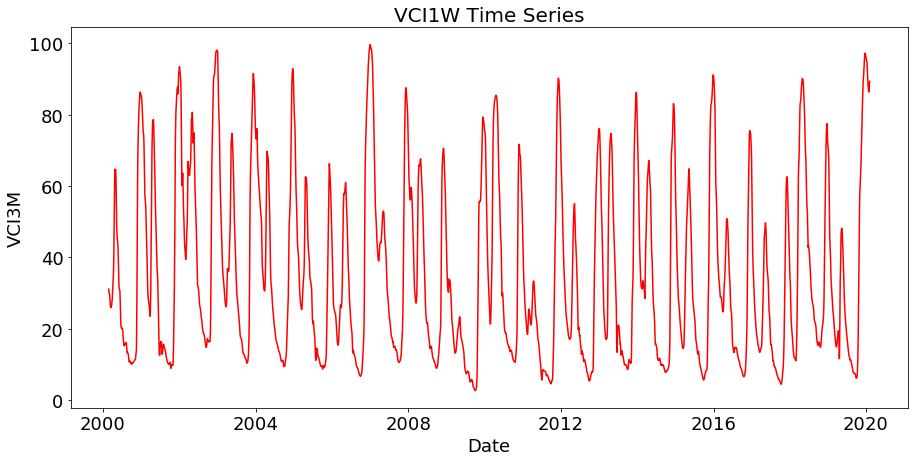

In [4]:
# List comprehension to change the format of the dates (Easier for plotting)

PlottingDates = [dt.datetime.strptime(date, "%d-%m-%Y").date() for date in Dates.tolist()]

# A more simple plotting code

# Setting the size for the plot

plt.figure(figsize=(15,7)) 

# Plotting the data and setting the colour and style of the line

plt.plot(PlottingDates,VCI1W,color='r',linestyle='-')

#Setting the size of the text on the x and y axis
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('VCI3M',size=18)
plt.xlabel('Date',size=18)
plt.title('VCI1W Time Series',size=20)
plt.show()

## Pick how many 'hindcasts' you want to perform
### For a more accurate uncertainty on the forecast more hindcasts are advisable, but the more done, the longer the processing time will be. (Roughly 20s per run)

In [5]:
# This will be the amount of weeks the program goes back, performs a prediction and compares it to the real data.
# It will automatically be ten weeks behind as we will be forecasting up to ten weeks in advance.

AmountOfHindcasts = 10

## Run the hindcasts

In [6]:
# Create empty arrays to store both hindcasts and actual values. 

Hindcasts = np.empty((AmountOfHindcasts,11))
ActualValues = np.empty((AmountOfHindcasts,11))

# Finding the remainder when the amount of data points is divided by 7. (Useful for turning daily values into weekly)

ToRemove = len(VCI3M) % 7

print('Number of Hindcasts Performed')

# This for loop performs the amount of hindcasts requested on the data. 
# It saves the hindcasts and the actual values so they can be compared.


for LoopCounter in range(1,AmountOfHindcasts+1):
    
    ToIgnore,ToIgnore2,ToIgnore3,Hindcasts[LoopCounter-1,:] = \
    Forecasting.GetForecastVCI(Dates[:-(LoopCounter*7)-(10*7)],VCI1W[:-(LoopCounter*7)-(10*7)],VCI3M[:-(LoopCounter*7)-(10*7)])
    
    ActualValues[LoopCounter-1,:] = np.flip(VCI3M[ToRemove:][::-7])[-11-LoopCounter:-LoopCounter]
    
    print(LoopCounter, end=" ") 

Number of Hindcasts Performed
1 2 3 4 5 6 7 8 9 10 

## Plot an example hindcast and the actual data to match

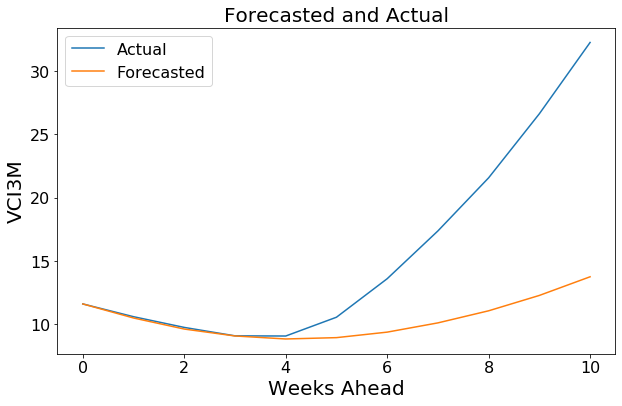

In [7]:
# Pick the hindcast you want to plot 

HindcastNo = 9

# Create an array with the week numbers ([0,1,2,3,...])

WeekNumbers = np.arange(0,len(Hindcasts[0]),1)

# Another, slightly more advanced code use to plot data.


# Set up the axis and the size of the plot

fig,ax1 = plt.subplots(figsize=(10,6))

# Plot the actual data against the weekumber, and on the same figure, plot the forecasted data.
# Label each line so that a key can be made to differentiate the two.

ax1.plot(WeekNumbers,ActualValues[HindcastNo],label='Actual')
ax1.plot(WeekNumbers,Hindcasts[HindcastNo],label='Forecasted')

# Set a title alongside some labels for the axes. Fontsize can also be changed.

ax1.set_title('Forecasted and Actual',fontsize=20)
ax1.set_ylabel('VCI3M',fontsize=20)
ax1.set_xlabel('Weeks Ahead',fontsize=20)

# Changing the fontsize of tick labels for both VCI3M (y) and Weeks ahead (x)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Plotting the legend (key) and showing the plot
plt.legend(fontsize=16)
plt.show()

## The results can now be analysed

#### We can calculate the R-squared metric and the RMSE metric by comparing the forecasted and actual data.

In [8]:
# How many weeks ahead you want to calculate for

ForecastWeek = 5

# Using a module called sklearn to calculate the metrics.

r2score = metrics.r2_score(ActualValues[:,ForecastWeek],Hindcasts[:,ForecastWeek])
RMSE    = metrics.mean_squared_error(ActualValues[:,ForecastWeek],Hindcasts[:,ForecastWeek])

# Printing out the R-Squared score and the RMSE.

print(r2score)
print(RMSE)

0.7933768945357632
51.06707706301542


#### Residual analysis

In [9]:
# Calculate the Residuals. This is simply the real value - the predicted value

Residuals = ActualValues - Hindcasts

# The mean and standard deviation of the residuals can now be calculated.

Mean = np.round(np.mean(Residuals,0),2)

StandardDeviation = np.round(np.std(Residuals,0),2)

# The standard deviation is used in the reports to give us an uncertainty.
# We use +/- two standard deviations so that we are 95% condfident our forecast will fall within it.

print('Mean',Mean)
print('Std ',StandardDeviation)



Mean [ 0.    0.35  0.91  1.77  3.05  4.79  6.94  9.43 12.18 15.08 18.06]
Std  [ 0.    0.61  1.53  2.68  3.96  5.3   6.71  8.18  9.68 11.29 13.02]


## Add the calibrated errors onto a new forecast.

#### Run the GP on the latest time series (Not a hindcast)

In [10]:
PredictionDates,WeeklyDates,WeeklyVCI3M,PredictedValues = Forecasting.GetForecastVCI(Dates,VCI1W,VCI3M)

## Pick how confident you want to be in the forecast

In [11]:
CountyErrors = StandardDeviation*2

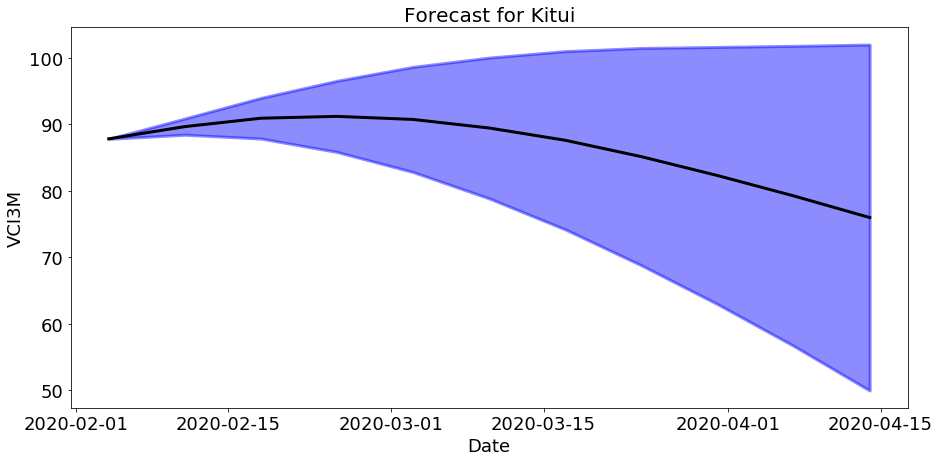

In [12]:
# Adjusting the figure size

fig,ax1 = plt.subplots(figsize=(15,7))

# Shading in the graph to represent the possible error on the forecast. (95% confidence interval)

ax1.fill_between(PredictionDates, PredictedValues-CountyErrors, PredictedValues+CountyErrors,lw=3,
                 color='blue',alpha=0.45)

# Plotting the actual forecast line

ax1.plot(PredictionDates,PredictedValues,linestyle = '-' ,lw = 3, color = 'black')

# Setting the title

ax1.set_title('Forecast for ' + County,size=20)

# Labeling the axes

ax1.set_ylabel('VCI3M',size=18)
ax1.set_xlabel('Date',size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.show()